In [399]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from common import colorFader, colorFaderRGB

In [400]:
# # quick test
# c1='darkblue' #blue
# c2='yellow' #green
# n=50

# fig, ax = plt.subplots(figsize=(4, 3))
# for x in range(n+1):
#     ax.axvline(x, color=colorFader(c1,c2,x/n), linewidth=4) 

In [401]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

c1 = COLORS['a']
c2 = COLORS['d']

colors = np.array([colorFaderRGB(c1, c2, x) for x in np.linspace(0, 1, 5)])
colors = np.column_stack([colors, np.ones(5)])

cmap = ListedColormap(colors, name='S5')

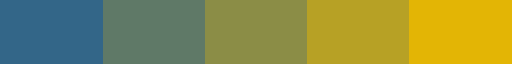

In [402]:
cmap

In [394]:
def draw_VR_objects(axes, y_shift=0, color='black'):
    # tall bars in the middle
    for x in np.array([-0.37, -0.18, -0.03]):
        rect = patches.Rectangle((x, -0.05 - y_shift), 0.12, 0.12, linewidth=1.2, ls='--', edgecolor=color, facecolor='none')
        axes.add_patch(rect)
        
    # virtual wall on the north
    axes.axhline(0.8 - y_shift, linewidth=1.2, ls='--', color=color)
    
    # maybe torus too?

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%matplotlib inline

import sys
#sys.path.append('/storage2/andrey/code/vrAnalysis/')
sys.path.append('/home/sobolev/storage2/andrey/code/vrAnalysis/')

import os
import h5py
#import nbimporter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.pyplot import figure
from scipy import stats as scipystats
from scipy import signal, interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable


from analysis.plots.utils import get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks, get_params_from_json
from analysis.processing.metrics import get_fields_between_epochs, get_field_pairs, get_lonely_fields
from analysis.adapters.hdf5 import H5NAMES

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Get sessions

In [6]:
COLORS = get_colors()

#storage_path = '/home/andrey/storage2'
#storage_path = '/storage2'
storage_path = '/home/sobolev/storage2'

source = os.path.join(storage_path, 'andrey/data/processed')
assets = os.path.join(storage_path, 'andrey/data/projects/24_shift/assets')
paper =  os.path.join(storage_path, 'andrey/data/projects/24_shift/PAPER')
bad_clu_dir = os.path.join(storage_path, 'andrey/data/projects/24_shift/bad_clusters')

animals = ['00908', '00910', '002784', '003281', '003282', '003908', '003909', '005363', '005364']  # all
animals = ['00908', '00910', '003281', '003282', '003908', '003909', '005363', '005364']  # no 002784
#animals = ['00908', '00910', '003281', '003282', '003909', '005363', '005364']
#animals = ['003281', '003282']

In [7]:
s_list_periodic_light = get_sessions_list(source, animals, 'SHIFT periodic')
s_list_periodic_dark = get_sessions_list(source, animals, 'SHIFT periodic +dark')
s_list_periodic_all = list(s_list_periodic_light) + list(s_list_periodic_dark)

s_list_single = get_sessions_list(source, animals, 'SHIFT single +dark')
s_list_all = list(s_list_single) + list(s_list_periodic_all)
s_list_with_dark = list(s_list_single) + list(s_list_periodic_dark)

len(s_list_all), len(s_list_with_dark)

(99, 52)

In [8]:
# or a single session
# sessions = [
#     ['003282', '2019-11-06_22-36-07'],
#     ['003282', '2019-11-18_10-35-43'],
# ]

# All shifts for all sessions in LIGHT
shift_A_B_all = get_fields_between_epochs(source, s_list_all, 'A', 'B')

# sessions with DARK present
shift_A_B = get_fields_between_epochs(source, s_list_with_dark, 'A', 'B')
shift_A_Ad = get_fields_between_epochs(source, s_list_with_dark, 'A', 'Ad')
shift_B_Bd = get_fields_between_epochs(source, s_list_with_dark, 'B', 'Bd')
shift_Ad_Bd = get_fields_between_epochs(source, s_list_with_dark, 'Ad', 'Bd')
shift_A_Bd = get_fields_between_epochs(source, s_list_with_dark, 'A', 'Bd')
shift_B_Ad = get_fields_between_epochs(source, s_list_with_dark, 'B', 'Ad')

No required H5 file found for 2020-10-23_12-57-03
PF match found for 1520 fields from total 3046 A and 3032 B fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 796 fields from total 1553 A and 1551 B fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 717 fields from total 1491 A and 1549 Ad fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 725 fields from total 1469 B and 1438 Bd fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 685 fields from total 1530 Ad and 1438 Bd fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 637 fields from total 1474 A and 1441 Bd fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 706 fields from total 1484 B and 1545 Ad fields


In [9]:
# lonely fields
#lonely_A_B_all = pd.concat([get_lonely_fields(source, rec[0], rec[1], 'A', 'B') for rec in s_list_all if rec is not None])
lonely_A_B = pd.concat([get_lonely_fields(source, rec[0], rec[1], 'A', 'B') for rec in s_list_with_dark if rec is not None])

No required H5 file found for 2020-10-23_12-57-03


In [10]:
print(list(shift_A_B_all))

['animal', 'session', 'electrode', 'unit', 'field_A', 'field_B', 'overlap_norm', 'sic_A', 'sic_B', 'isol_dist', 'peak_FR_A', 'peak_FR_B', 'COMa_x', 'COMa_y', 'COMb_x', 'COMb_y', 'shift', 'size_A', 'size_B']


# Filters

## Bad fields

- information content > 0.2
- peak firing rate > 1.5Hz
- isolation distance > 15

In [11]:
def get_idxs_by_quality(dataset):
    sic, pfr, iso = 0.2, 1.5, 15    # sic > 0.2, peak firing rate > 1.5 Hz, isolation distance > 15
    idxs_sic = (dataset['sic_A'] > sic) & (dataset['sic_B'] > sic)
    idxs_pfr = (dataset['peak_FR_A'] > pfr) & (dataset['peak_FR_B'] > pfr)
    idxs_iso = (dataset['isol_dist'] > iso)
    return idxs_sic & idxs_pfr & idxs_iso

In [12]:
def get_idxs_by_shift_range(dataset, s_min, s_max):
    return (dataset['shift'] > s_min) & (dataset['shift'] < s_max)

In [13]:
def get_idxs_of_good_clu(ds):
    col_types = {'animal': str, 'session': str, 'electrode': int, 'unit': int}
    bad_clu = pd.read_csv(os.path.join(bad_clu_dir, 'all.csv'), dtype=col_types)
    
    all_idxs = np.array(ds.index.tolist())
    df = ds.copy()
    df['idxs'] = all_idxs
    
    bad_idxs = np.array(df.merge(bad_clu, on=['animal', 'session', 'electrode', 'unit'], how='inner')['idxs'])
    return np.isin(all_idxs, bad_idxs, invert=True)

# ANALYSIS

In [14]:
grps = {
    'b': [-0.1, 0.0],
    'v': [0.3, 0.4]
}

### shift histogram

In [15]:
# detect lost fields
lon_AB = lonely_A_B.copy()
lon_AB = lon_AB[(lon_AB['sic'] > 0.15) & (lon_AB['isol_dist'] > 20) & (lon_AB['peak_FR'] > 1.5)]

lon_A_B = lon_AB[(lon_AB['cond'] == 'A') & (lon_AB['COMa_y'] < -0.7)]
lon_B_A = lon_AB[(lon_AB['cond'] == 'B') & (lon_AB['COMa_y'] > 0.7)]

print('Selected %s A-B and %s B-A lost fields' % (len(lon_A_B), len(lon_B_A)))

Selected 41 A-B and 49 B-A lost fields


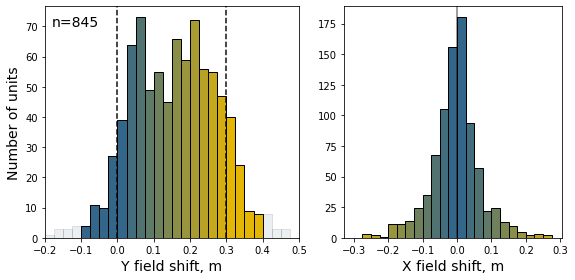

In [59]:
df = shift_A_B_all.copy()
df['shift'] = (-1) * (df['shift'] - 0.3)

df = df[get_idxs_of_good_clu(df)]
df = df[get_idxs_by_quality(df)]

df_00 = df[(df['shift'] > grps['b'][0]) & (df['shift'] < grps['b'][1])]
#df_15 = df[(df['shift'] > grps['h'][0]) & (df['shift'] < grps['h'][1])]
df_30 = df[(df['shift'] > grps['v'][0]) & (df['shift'] < grps['v'][1])]
df_   = df[(df['shift'] < grps['b'][0]) | (df['shift'] > grps['v'][1])]
df_in = df[(df['shift'] > grps['b'][0]) & (df['shift'] < grps['v'][1])]

bins = np.arange(-0.4, 0.6, 0.025)
fig, axs = plt.subplots(1, 2, gridspec_kw={
    'width_ratios': [7, 6]})
fig.set_figheight(4)
fig.set_figwidth(8)

# --------- Y-Axis ----------

ax = axs[0]
ax.set_xlim(-0.2, 0.5)
N, bins, patches = ax.hist(df_in['shift'], bins=bins, color=COLORS['d'], ec='black')
ax.hist(df_00['shift'], bins=bins, color=COLORS['a'], ec='black')
#ax.hist(df_30['shift'], bins=bins, color=COLORS['c'], ec='black')
ax.hist(df_['shift'],   bins=bins, color=COLORS['a'], ec='black', alpha = 0.1)

bin_l = np.abs((bins + 0.0)).argmin()
bin_r = np.abs((bins - 0.3)).argmin()
for i in range(bin_l, bin_r):
    patches[i].set_facecolor(colorFader(COLORS['a'], COLORS['d'], (i-bin_l)/(bin_r - bin_l)))

ax.axvline(0, color='black', ls='--', alpha=0.95)
ax.axvline(0.3, color='black', ls='--', alpha=0.95)
ax.set_xlabel('Y field shift, m', fontsize=14)
ax.set_ylabel('Number of units', fontsize=14)
ax.text(-0.18, 70, 'n=%d' % len(df), fontsize=14, color='black')
#ax.text(-0.28, 64, 'Hybrid (%d)' % len(df_15), fontsize=14, color=COLORS['c'])
#ax.text(-0.28, 64, 'Visual (%d)' % len(df_30), fontsize=14, color=COLORS['d'])

ker = scipystats.gaussian_kde(df['shift'], bw_method=0.15)
x_vals = np.linspace(-0.2, 0.5, 100)
#ax.plot(x_vals, 18*ker(x_vals), color='black', alpha=0.5, lw=3, ls='--')

# --------- X-axis -------

idxs_x_l = np.where(df['COMb_x'] - df['COMa_x'] < 0)[0]
idxs_x_r = np.where(df['COMb_x'] - df['COMa_x'] > 0)[0]
shift_x_l = df.iloc[idxs_x_l]['COMb_x'] - df.iloc[idxs_x_l]['COMa_x']
shift_x_r = df.iloc[idxs_x_r]['COMb_x'] - df.iloc[idxs_x_r]['COMa_x']

ax = axs[1]
# left
N, bins, patches = ax.hist(shift_x_l, np.arange(-0.3, 0.3, 0.025), color=COLORS['a'], ec='black')
for i in range(0, int(len(bins)/2)):
    patches[i].set_facecolor(colorFader(COLORS['a'], COLORS['d'], 1 - (i+1)/(len(bins)/2)))

N, bins, patches = ax.hist(shift_x_r, np.arange(-0.3, 0.3, 0.025), color=COLORS['c'], ec='black')
for i in range(int(len(bins)/2), len(bins)-1):
    patches[i].set_facecolor(colorFader(COLORS['a'], COLORS['d'], (i - len(bins)/2)/(len(bins)/2)))

ax.axvline(0.0, color='black', alpha=0.5)
ax.set_xlabel('X field shift, m', fontsize=14)

fig.tight_layout()
filename = "1g.pdf"
#fig.savefig(os.path.join(os.path.join(paper), filename))

## Same but KDE

In [84]:
b_l, width, step, bc = -0.1, 0.2, 0.1, 5
b_s = np.arange(b_l, b_l + bc*step, step)
b_e = np.arange(b_l + width, b_l + width + bc*step, step)
spl_grps = np.column_stack([b_s, b_e])

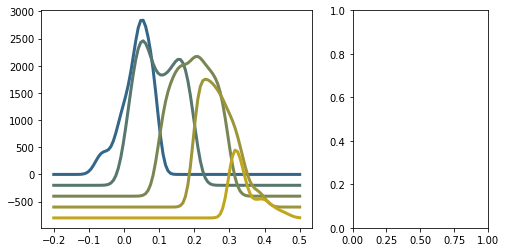

In [85]:
bins = np.arange(-0.4, 0.6, 0.025)
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
fig.set_figheight(4)
fig.set_figwidth(8)

x_vals = np.linspace(-0.2, 0.5, 100)
for i, bounds in enumerate(spl_grps):
    df_sel = df[(df['shift'] > bounds[0]) & (df['shift'] < bounds[1])]
    
    ker_p = scipystats.gaussian_kde(df_sel['shift'], bw_method=0.35)
    
    clr = colorFader(COLORS['a'], COLORS['d'], i/len(spl_grps))
    axs[0].plot(x_vals, ker_p(x_vals)*len(df_sel['shift']) - i*200, color=clr, lw=3, ls='-', label='pSHIFT')

## Shift relative to the boudary - all

In [150]:
df = shift_A_B_all.copy()
df['shift'] = (-1) * (df['shift'] - 0.3)

df = df[get_idxs_of_good_clu(df)]
df = df[get_idxs_by_quality(df)]

# Y-direction
# include field positions from A and B
y_dist_to_b = -1 * (np.abs(np.concatenate([df['COMa_y'] + 0.15, df['COMb_y'] - 0.15])) - 0.85)  # Y-positions of each field in A/B rel to boundary
y_f_shift = np.tile(df['shift'], 2)

# take only A 
#y_dist_to_b = np.array(-1 * (np.abs(df['COMa_y'] + 0.15) - 0.85))  # Y-positions of each field in A/B rel to boundary

# or B positions
#y_dist_to_b = np.array(-1 * (np.abs(df['COMb_y'] - 0.15) - 0.85))  # Y-positions of each field in A/B rel to boundary

#y_f_shift = np.array(df['shift'])

# X-direction
# include field positions from A and B
x_dist_to_b = -1 * (np.abs(np.concatenate([df['COMa_x'], df['COMb_x']])) - 0.35)  # Y-positions of each field in A/B rel to boundary
x_f_shift = np.tile(df['shift'], 2)

In [151]:
len(y_dist_to_b), len(y_f_shift)

(1690, 1690)

In [217]:
xy_stats = {}
conds  = ['X', 'Y']
dists  = [x_dist_to_b, y_dist_to_b]
shifts = [x_f_shift, y_f_shift]
bins_a = [np.linspace(0.0, 0.35, 10), np.linspace(0, 0.85, 16)]
offsets = [0.05, 0.05]

for c_id in range(2):
    means, medians, stds, stde, intervals = [], [], [], [], []
    bins = bins_a[c_id]
    dist_to_b = dists[c_id]
    f_shift   = shifts[c_id]
    
    for i in range(len(bins) - 1):
        idxs = np.where((dist_to_b > bins[i]) & (dist_to_b < bins[i+1]))[0]
        k_slice = f_shift[idxs]

        means.append(np.mean(k_slice))
        medians.append(np.median(k_slice))
        stds.append(np.std(k_slice))
        stde.append(scipystats.sem(k_slice))

        j_min, j_max = scipystats.t.interval(0.95, len(k_slice)-1, loc=np.median(k_slice), scale=scipystats.sem(k_slice))
        intervals.append([j_min, j_max])

    k_stats = {}
    k_stats['intervals'] = np.array(intervals)
    k_stats['means'] = np.array(means)
    k_stats['medians'] = np.array(medians)
    k_stats['stds'] = np.array(stds)

    slope, intercept, r_value, p_value, std_err = scipystats.linregress(dist_to_b, f_shift)
    #st, pv = scipystats.kruskal(x_vals, y_vals)
    k_stats['slope'] = slope
    k_stats['p_value'] = p_value
    
    xy_stats[conds[c_id]] = k_stats

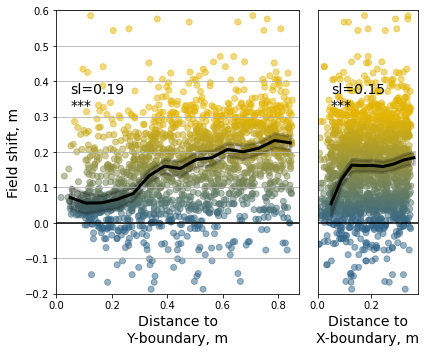

In [227]:
def get_color_for_shift(shift):
    if shift < 0:
        return COLORS['a']
    elif shift > 0.3:
        return COLORS['d']
    else:
        return colorFader(COLORS['a'], COLORS['d'], shift/0.3)


fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [bins_a[1][-1], bins_a[0][-1]]}, figsize=(6, 5))

for i, ax in enumerate(axes):
    idx_cond = (i+1) % 2
    dist_to_b = dists[idx_cond]
    f_shift   = shifts[idx_cond]
    cst = xy_stats[conds[idx_cond]]
    offset = offsets[idx_cond]
    bins = bins_a[idx_cond]
    clrs = [get_color_for_shift(shift) for shift in f_shift]

    #ker = scipystats.gaussian_kde(dist_to_b, bw_method=0.15)
    #x_vals = np.linspace(bins[0]-0.1, bins[-1]+0.05, 50)
    
    ax.scatter(dist_to_b, f_shift, alpha=0.5, c=clrs)
    
    #ax.plot(x_vals, ker(x_vals), lw=3, color='black')
    
    ax.plot(bins_a[idx_cond][:-1] + offset, cst['medians'], lw=3, color='black')
    ax.fill_between(bins_a[idx_cond][:-1] + offset, cst['intervals'][:, 0], cst['intervals'][:, 1], lw=3, alpha=0.2, color='black')

    ax.yaxis.grid()
    ax.set_xlabel('Distance to\n%s-boundary, m' % conds[idx_cond], fontsize=14)
    ax.axhline(0, color='black')
    ax.text(0.05, 0.32, 'sl=%.2f\n***' % cst['slope'], fontsize=14)
    ax.set_ylim(-0.2, 0.6)
    ax.set_xlim(0, bins_a[idx_cond][-1] + 0.025)

axes[0].set_ylabel('Field shift, m', fontsize=14)
axes[1].set_yticks([])
axes[1].yaxis.grid()

fig.tight_layout()

## Field density

In [245]:
# groups for distance to boundary
# b_l, width, step, bc = 0, 0.2, 0.17, 5
# b_s = np.arange(b_l, b_l + bc*step, step)
# b_e = np.arange(b_l + width, b_l + width + bc*step, step)
# fd_grps = np.column_stack([b_s, b_e])
# fd_grps

In [246]:
# groups for shift
b_l, width, step, bc = -0.1, 0.2, 0.1, 5
b_s = np.arange(b_l, b_l + bc*step, step)
b_e = np.arange(b_l + width, b_l + width + bc*step, step)
fd_grps = np.column_stack([b_s, b_e])
fd_grps

array([[-0.1,  0.1],
       [ 0. ,  0.2],
       [ 0.1,  0.3],
       [ 0.2,  0.4],
       [ 0.3,  0.5]])

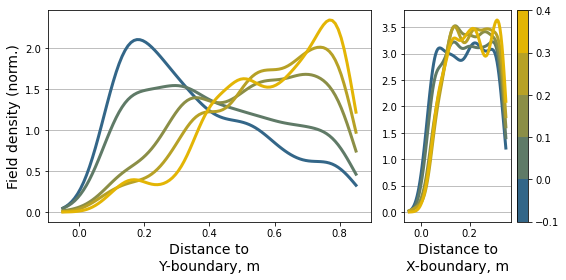

In [291]:
bins_a = [np.linspace(0.0, 0.35, 10), np.linspace(0, 0.85, 16)]
offsets = [0.05, 0.05]

fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [bins_a[1][-1], bins_a[0][-1]]})
fig.set_figheight(4)
fig.set_figwidth(8)



for j, ax in enumerate(axes):
    idx_cond = (j+1) % 2
    f_shift   = shifts[idx_cond]
    dist_to_b = dists[idx_cond]
    x_vals = np.linspace(bins_a[idx_cond][0] - 0.05, bins_a[idx_cond][-1], 100)
    
    for i, bounds in enumerate(fd_grps):
        # filter by distance to boundary
        #idxs_sel = np.where((dist_to_b > bounds[0]) & (dist_to_b < bounds[1]))[0]

        # filter by shift
        idxs_sel = np.where((f_shift > bounds[0]) & (f_shift < bounds[1]))[0]

        ker_p = scipystats.gaussian_kde(dist_to_b[idxs_sel], bw_method=0.25)
        clr = colorFader(COLORS['a'], COLORS['d'], i/(len(fd_grps)-1))
        ax.plot(x_vals, ker_p(x_vals), color=clr, lw=3, ls='-', label='pSHIFT')
        #axs[0].plot(x_vals, ker_p(x_vals)*len(df_sel['shift']) - i*200, color=clr, lw=3, ls='-', label='pSHIFT')
        
    ax.yaxis.grid()
    #ax.set_xlim()
    ax.set_xlabel('Distance to\n%s-boundary, m' % conds[idx_cond], fontsize=14)

axes[0].set_ylabel('Field density (norm.)', fontsize=14)

# https://stackoverflow.com/questions/43805821/matplotlib-add-colorbar-to-non-mappable-object
norm = mpl.colors.Normalize(vmin=-0.1, vmax=0.4)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = fig.colorbar(sm, ax=axes[1])

fig.tight_layout()
#sm.set_array([])
#plt.colorbar(sm, ticks=np.linspace(0,2,N), 
#             boundaries=np.arange(-0.05,2.1,.1))

### Occupancy / speed - SINGLE / PERIODIC shift

In [323]:
from analysis.processing.epochs import get_epochs
from analysis.plots.utils import get_figure_size, get_extent
from analysis.models.analytics import gaussian_kernel_2D

import matplotlib.patches as patches

from functools import reduce

In [306]:
def get_trajectory_in_arena_rf(h5file):
    with h5py.File(h5file, 'r') as f:
        trajectory = np.array(f['animal_trajectory'])
        arena_trajectory = np.array(f['arena_trajectory'])

    # bring to arena coordinate system
    a_min, a_max = arena_trajectory[:, 2].min(), arena_trajectory[:, 2].max()
    arena_trajectory[:, 2] -= a_min
    trajectory[:, 2] -= arena_trajectory[:len(trajectory), 2] - ( (a_max - a_min)/2 )
    
    return trajectory

In [307]:
def get_occ_and_speed(sessions_list, bin_size=0.03):
    # get a session for common variables
    animal, session = sessions_list[0][0], sessions_list[0][1]
    occupancies = []
    speeds = []

    # use first session to get common params
    h5file = os.path.join(source, animal, session, 'all.h5')
    trajectory = get_trajectory_in_arena_rf(h5file)
    conditions = get_epochs(os.path.join(source, animal, session))

    kernel = gaussian_kernel_2D(0.1)
    
    # let's set the same for all
    #limits = get_figure_size(trajectory[:, 1:3])
    #extent = get_extent(trajectory[:, 1:3])
    #x_min, x_max = trajectory[:, 1].min(), trajectory[:, 1].max()
    #y_min, y_max = trajectory[:, 2].min(), trajectory[:, 2].max()
    
    extent = (-0.4, 0.4, -0.85, 0.85)
    limits = (extent[0] - 0.1, extent[1] + 0.1, extent[2] - 0.1, extent[3] + 0.1)
    x_min, x_max, y_min, y_max = extent
    
    pos_range = np.array([[x_min, x_max], [y_min, y_max]])

    x_range = x_max - x_min
    y_range = y_max - y_min
    y_bin_count = int(np.ceil(y_range / bin_size))
    x_bin_count = int(np.ceil(x_range / bin_size))

    for animal, session, s_type in [s for s in sessions_list]:
        sessionpath = os.path.join(source, animal, session)
        conditions = get_epochs(sessionpath)
        h5file = os.path.join(sessionpath, 'all.h5')

        if not os.path.exists(h5file):
            continue

        trajectory = get_trajectory_in_arena_rf(h5file) 
        sampling_rate = float(round((np.ones(len(trajectory) - 1)/np.diff(trajectory[:, 0])).mean()))

        occup_temp = {}
        speed_temp = {}
        for i, cond in enumerate(conditions):
            with h5py.File(h5file, 'r') as f:
                cond_idxs = np.array(f['%s_idxs' % cond])
                velocity = np.array(f['velocity'])
                velocity = np.append(velocity, [velocity[-1]], axis=0)
                #trajectory = np.array(f['animal_trajectory'])[:, 3]  # t, x, y

            #diffs = np.diff(trajectory[:, :3], axis=0)
            #velocity_Y = diffs[:, 2] / diffs[:, 0]  # dy/dt, only Y-component of the velocity
            #velocity_Y = np.sqrt(np.square(diffs[:, 1]) + np.square(diffs[:, 2])) / diffs[:, 0]  # real velocity
            #velocity_Y = np.append(velocity_Y, 0)
            #weights = velocity_Y[cond_idxs]
            
            pos = trajectory[cond_idxs]
            weights = velocity[cond_idxs][:, 1]  # real velocity
            
            occup, _, _ = np.histogram2d(pos[:, 1], pos[:, 2], bins=[x_bin_count, y_bin_count], range=pos_range)
            speed, _, _ = np.histogram2d(pos[:, 1], pos[:, 2], bins=[x_bin_count, y_bin_count], density=True, weights=weights, range=pos_range)

            occup_temp[cond] = occup / sampling_rate
            #print(sampling_rate, len(pos)/(60.*sampling_rate), len(trajectory)/(60.*sampling_rate), occup_temp[cond].sum())
            #speed_temp[cond] = np.nan_to_num(speed/occup_temp[cond])
            speed_temp[cond] = speed/occup_temp[cond]

        occupancies.append(occup_temp)
        speeds.append(speed_temp)

    # sum across sessions within each condition
    occ_all = {}
    for cond in conditions:
        selection = [occ[cond] for occ in occupancies if cond in occ]
        occ_sum = reduce((lambda x, y: x + y), selection)
        occ_all[cond] = occ_sum/len(selection)

    speed_all = {}
    for cond in conditions:
        colnan = [sp[cond] for sp in speeds if cond in sp]

        result = []
        n, m = np.array(colnan[0]).shape
        for i in range(n):
            for j in range(m):
                result.append(np.nanmean( [x[i, j] for x in colnan] ))

        result = np.array(result)
        result[np.isnan(result)] = 0.
        result = np.reshape(np.array(result), (-1, m))        
        
        #speed_all[cond] = sp_sum/len(selection)        
        speed_all[cond] = result/float(len(colnan))
        
    return conditions, occ_all, speed_all, extent, limits

In [292]:
periodic = get_sessions_list(source, animals, 'SHIFT periodic +dark')
single = get_sessions_list(source, animals, 'SHIFT single +dark')

In [309]:
conditions, occ_all_ps, speed_all_ps, extent, limits = get_occ_and_speed(periodic + single)  
# merge with single? there will be bias in speed for the B then

# merge dark into one condition
conditions = ('A', 'B', 'D')
occ_all_ps['D'] = occ_all_ps['Ad'] + occ_all_ps['Bd']
del occ_all_ps['Ad']
del occ_all_ps['Bd']
speed_all_ps['D'] = speed_all_ps['Ad']
del speed_all_ps['Ad']
del speed_all_ps['Bd']

/tmp/ipykernel_5618/908396407.py:66: RuntimeWarning: invalid value encountered in divide
  speed_temp[cond] = speed/occup_temp[cond]
/tmp/ipykernel_5618/908396407.py:86: RuntimeWarning: Mean of empty slice
  result.append(np.nanmean( [x[i, j] for x in colnan] ))


In [395]:
def plot_arena_stats(maps, extent, limits, titles, hlines=[], cbar_label=''):
    fig = figure(figsize=(2*len(maps), 4))
    kernel = gaussian_kernel_2D(0.1)

    vmax = np.array([signal.convolve2d(occ, kernel, mode='same').max() for occ in maps.values()]).max()
    collected = []
    for i, cond in enumerate(sorted(maps.keys())):
        occupancy_map = maps[cond]
        occupancy_map = signal.convolve2d(occupancy_map, kernel, mode='same')

        ax = fig.add_subplot(1, len(maps.keys()), i+1)
        ax.set_xticks([])
        if i > 0:
            ax.set_yticklabels([])
        ax.set_xlim(limits[0], limits[1])
        ax.set_ylim(limits[2], limits[3])
        ax.grid()
        ax.set_title(titles[i], fontsize=14)
        for hline in hlines:
            ax.axhline(hline, color=COLORS['a'], ls='--')
        posPFA = ax.imshow(np.flip(occupancy_map.T, axis=1), cmap='jet', origin='lower', extent=extent,\
                               vmax=vmax, alpha=1)
        collected.append(np.flip(occupancy_map.T, axis=1))

        # virtual walls etc.
        draw_VR_objects(ax, y_shift=0.3*i)

    cax = fig.add_axes([ax.get_position().x1 + 0.02, ax.get_position().y0, 0.02, ax.get_position().height])
    cbar = plt.colorbar(posPFA, cax=cax) # Similar to fig.colorbar(im, cax = cax)
    cbar.set_label(cbar_label, fontsize=14)
    
    return collected, fig

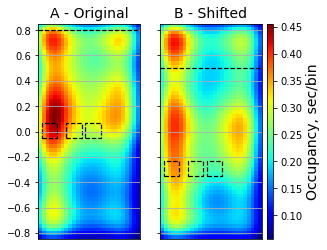

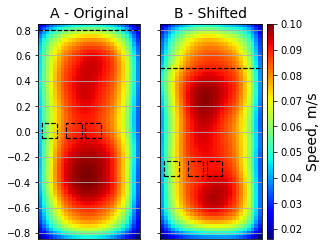

In [396]:
titles = ['A - Original', 'B - Shifted', 'D - Dark', 'B - A']
limits = (extent[0], extent[1], extent[2], extent[3])

occ_all_p = occ_all_ps.copy()
speed_all_p = speed_all_ps.copy()
del speed_all_p['D']
del occ_all_p['D']

#occ_all_p['zAB'] = occ_all_p['B'] - occ_all_p['A']
occ_plotted, fig = plot_arena_stats(occ_all_p, extent, limits, titles, cbar_label='Occupancy, sec/bin')
filename = "1d_1.pdf"
#fig.savefig(os.path.join(os.path.join(paper), filename))

# xb, yb = speed_all_p['A'].shape
# speed_A = np.log(speed_all_p['A'].flatten()).reshape(xb, yb)
# speed_all_p['A'] = speed_A

spd_plotted, fig = plot_arena_stats(speed_all_p, extent, limits, titles, cbar_label='Speed, m/s')
filename = "1d_2.pdf"
#fig.savefig(os.path.join(os.path.join(paper), filename))